In [3]:
import warnings
warnings.filterwarnings('ignore')

import torch
import transformers
import torchvision
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

import cv2
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk import Text

import editdistance
from torchsummary import summary

seed = 42

In [4]:
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
from IPython.display import clear_output
from kobert_transformers import get_tokenizer


tokenizer = get_tokenizer()

MAX_SEQ_LEN = 120  #최대 글자 수 
LR = 5e-5 # Learning Rate
EPOCHS = 30
IMAGE_SIZE = 256 #256x256
BATCH_SIZE = 10  
HIDDEN = 512 
ENC_LAYERS = 4 # transformer encoder layer 수
DEC_LAYERS = 4 # transformer decoder layer 수
N_HEADS = 8 
DROPOUT = 0.1
PATH = r'caption_model.pth'
VOCAB_SIZE = tokenizer.vocab_size
clear_output()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device')

Currently using "CUDA" device


In [7]:
path ='/workspace/IMAGE/images/sport'  #여기서 이미지 파일 조정 가능 
data = np.zeros((10001, 2), dtype=np.object) #현재 158916개의 데이터셋
i = 0
for line in open('/workspace/IMAGE/sport.txt', 'r', encoding='cp949'):
    data[i, :] = line.replace('\n', "").split('|')
    i += 1
    
df = pd.DataFrame(data=data[1:, :], columns=data[0, :])
df.sample(5)
df.head()

UnicodeDecodeError: 'cp949' codec can't decode byte 0x9d in position 37: illegal multibyte sequence

In [18]:
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.RandomCrop(IMAGE_SIZE),
                              T.ColorJitter(brightness=(0.95, 1.05),
                                            contrast=(0.95, 1.05),
                                            saturation=(0.98, 1.02),
                                            hue=0.05),
                              T.RandomHorizontalFlip(p=0.1),
                              T.GaussianBlur(kernel_size=(1, 3), sigma=(0.1, 0.5)),
                              T.RandomAdjustSharpness(sharpness_factor=1.2, p=0.2),
                              T.RandomRotation(degrees=(-5, 5)),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], 
                                          std=[0.229, 0.224, 0.225])
])

valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], 
                                          std=[0.229, 0.224, 0.225])
])
invTrans = T.Compose([T.Normalize(mean = [ 0., 0., 0. ],
                                      std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                          T.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                      std = [ 1., 1., 1. ]),
                          T.ToPILImage(),
                         ])

In [19]:
root = '/workspace/IMAGE/images/images'

class CapDataset(Dataset):
    def __init__(self, df, root, tokenizer, transforms=None):
        self.df = df
        self.root = root
        self.tokenizer = tokenizer
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        row = self.df.iloc[ix].squeeze()
        id = row.image_name
        image_path = f'{self.root}/{id}'

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        caption = row.caption_text

        target = tokenizer(caption, 
                           return_token_type_ids=False, 
                           return_attention_mask=False, 
                           max_length=MAX_SEQ_LEN, 
                           padding="do_not_pad",
                           return_tensors="pt")
        target = target['input_ids'].squeeze()
        target = torch.LongTensor(target)
        return image, target, caption

    def collate_fn(self, batch):
        batch.sort(key=lambda x: len(x[1]), reverse=True)
        images, targets, captions = zip(*batch)
        images = torch.stack([self.transforms(image) for image in images], 0)
        lengths = [len(tar) for tar in targets]
        _targets = torch.zeros(len(captions), max(lengths)).long()
        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end] 
        _targets = _targets.permute(1,0)
        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)

In [20]:
train, test = train_test_split(df, test_size=0.01, shuffle=True, random_state=seed)
train, valid = train_test_split(train, test_size=0.1, shuffle=True, random_state=seed)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print(f'Train size: {train.shape[0]}, valid size: {valid.shape[0]}, test size: {test.shape[0]}')

Train size: 8910, valid size: 990, test size: 100


In [21]:
train_dataset = CapDataset(train, root, tokenizer, train_transforms)
valid_dataset = CapDataset(valid, root, tokenizer, valid_transforms)
test_dataset = CapDataset(test, root, tokenizer, valid_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=test_dataset.collate_fn)

In [22]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=8, pretrained=True):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=pretrained)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        for param in self.resnet.parameters():
            param.requires_grad = False

        for child in list(self.resnet.children())[5:]:
            for param in child.parameters():
                param.requires_grad = True
                
        self.fc = nn.Sequential(nn.Conv2d(2048, 512, 1),
                                nn.LeakyReLU(0.01, inplace=True))
        #Encoder 정의 
        #Convolution layer와 RELU 활용        

    def forward(self, images):
        out = self.resnet(images)
        out = self.fc(out)
        out = self.adaptive_pool(out) # [B, C, H, W] pooling layer
        #out = out.permute(0, 3, 1, 2)
        out = out.flatten(2) # [B, C, HW] flattern layer 
        out = out.permute(2,0,1) # [HW, B, C] 
        return out
        
        # [HW, B, C]는 vector의 shape

class Encoder_50(nn.Module):
    def __init__(self, bb_name='resnet50', hidden=HIDDEN, pretrained=False):
        super(Encoder_50, self).__init__()
        self.backbone = torchvision.models.__getattribute__(bb_name)(pretrained=pretrained)
        self.backbone.fc = nn.Conv2d(2048, hidden, 1)
    
    def forward(self, src):
        x = self.backbone.conv1(src)

        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x) # [32, 2048, 8, 8] : [B,C,H,W]
            
        x = self.backbone.fc(x) # [32, 512, 8, 8] : [B,C,H,W]
        # x = x.permute(0, 3, 1, 2) # [64, 8, 512, 8] : [B,W,C,H]
        x = x.flatten(2) # [32, 512, 64] : [B,C,WH]
        #x = x.permute(1, 0, 2) # [64, 32, 512] : [W,B,CH]
        x = x.permute(2,0,1)
        return x
    
class TransformerModel(nn.Module):
  #TransformerModel 정의
    def __init__(self, outtoken, hidden, enc_layers=1, dec_layers=1, nhead=1, dropout=0.1, pretrained=False):
        super(TransformerModel, self).__init__()
        self.backbone = Encoder_50(pretrained=pretrained)
        
        self.pos_emb = nn.Embedding.from_pretrained(self.get_position_embedding_table(), freeze=True) ##
        self.pos_encoder = PositionalEncoding(hidden, dropout)
        self.decoder = nn.Embedding(outtoken, hidden, padding_idx=0)
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        self.transformer = nn.Transformer(d_model=hidden, nhead=nhead, num_encoder_layers=enc_layers,
                                          num_decoder_layers=dec_layers, dim_feedforward=hidden * 4, dropout=dropout,
                                          activation='gelu')  # 'relu' or torch.nn.functional.leaky_relu

        self.fc_out = nn.Linear(hidden, outtoken)
        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None
        
    def get_position_embedding_table(self, num_pix=8, ch_pos=256): ##
        def cal_angle(position, hid_idx):
            x = position % num_pix
            y = position // num_pix
            x_enc = x / np.power(10000, hid_idx / ch_pos)
            y_enc = y / np.power(10000, hid_idx / ch_pos)
            return np.sin(x_enc), np.sin(y_enc)
        def get_posi_angle_vec(position):
            return [cal_angle(position, hid_idx)[0] for hid_idx in range(ch_pos)] + [cal_angle(position, hid_idx)[1] for hid_idx in range(ch_pos)]

        embedding_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(int(num_pix**2))])
        return torch.FloatTensor(embedding_table).to(device)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)

    def forward(self, src, trg):
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(device) 
        x = self.backbone(src)
        
        batch_size = x.size(1) ##
        positions = x.size(0) ##
        
        src_pad_mask = self.make_len_mask(x[:, :, 0])
        #src = self.pos_encoder(x)
        pos_emb = self.pos_emb(torch.LongTensor([list(range(positions))]*batch_size).to(device)) # [32,64,512]
        src = x + pos_emb.permute(1,0,2) #
        
        trg_pad_mask = self.make_len_mask(trg)
        trg = self.decoder(trg)
        trg = self.pos_decoder(trg)

        output = self.transformer(src, trg, src_mask=self.src_mask, tgt_mask=self.trg_mask,
                                  memory_mask=self.memory_mask,
                                  src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=trg_pad_mask,
                                  memory_key_padding_mask=src_pad_mask) #  [HW,B,C]
        output = self.fc_out(output) # [L,B,C]

        return output
    
class PositionalEncoding(nn.Module):
  #Position Embading
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x) 

In [23]:
def train_one_batch(model, data, optimizer, criterion):
    model.train()
    image, target, _ = data
    optimizer.zero_grad()
    output = model(image, target[:-1, :])
    
    if torch.any(torch.isnan(output)): 
        output = torch.nan_to_num(output)
        
    loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(target[1:, :], (-1,)))
    loss.backward()
    optimizer.step()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0) 
    
    accuracy = (output.argmax(2).flatten() == target[1:, :].flatten()).float().mean().item()
    return loss.item(), accuracy

@torch.no_grad()
def validate_one_batch(model, data, criterion):
    model.eval()
    image, target, _ = data
    output = model(image, target[:-1, :])
    if torch.any(torch.isnan(output)):
        output = torch.nan_to_num(output)
    loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(target[1:, :], (-1,)))
    accuracy = (output.argmax(2).flatten() == target[1:, :].flatten()).float().mean().item()
    return loss.item(), accuracy

@torch.no_grad()
def prediction(model, filepath='random', max_len=MAX_SEQ_LEN, tokenizer=tokenizer, plot=True):
    label = None
    if filepath == 'random':
        idx = np.random.randint(len(test))
        filepath = root + '/' + test.iloc[idx, 0]
        label = test.iloc[idx, -1]

    model.eval()
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = valid_transforms(img)
    src = torch.FloatTensor(image).unsqueeze(0).to(device)

    out_indexes = [101, ]

    for i in range(max_len):
                
        trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                
        output = model(src, trg_tensor)
        out_token = output.argmax(2)[-1].item()
        if out_token == 102:
            break
        out_indexes.append(out_token)

    preds = tokenizer.decode(out_indexes[1:])
    if plot:
        plt.figure(figsize=(6,4))
        plt.title("Predicted / Truth")
        plt.imshow(img)
        plt.tight_layout()
        plt.show()
        plt.pause(0.001)
        print(f'Prediction: {preds}, \nTruth: {label if label is not None else "NO label"}')
    
    return preds

In [24]:
def bleu_score_fn(method_no: int = 4, ref_type='corpus'):
    smoothing_method = getattr(SmoothingFunction(), f'method{method_no}')
    
    def bleu_score_corpus(reference_corpus: list, candidate_corpus: list, n: int = 4):
        weights = [1 / n] * n
        return corpus_bleu(reference_corpus, candidate_corpus,
                           smoothing_function=smoothing_method, weights=weights)

    def bleu_score_sentence(reference_sentences: list, candidate_sentence: list, n: int = 4):
        weights = [1 / n] * n
        return sentence_bleu(reference_sentences, candidate_sentence,
                             smoothing_function=smoothing_method, weights=weights)
    if ref_type == 'corpus':
        return bleu_score_corpus
    elif ref_type == 'sentence':
        return bleu_score_sentence
    #이미지 캡셔닝 특성상 정답 sequnce와 비교하는 것이기 때문에 BLUE로 evaluation하는 경우가 많음.
@torch.no_grad()
def evaluate_model(dataloader, model, bleu_score_fn, tokenizer):
    running_bleu = [0.0] * 5
    model.eval()
    for batch_idx, batch in enumerate(tqdm(dataloader, leave=False)):
        images, captions, _ = batch
        outputs = []
        for j in range(images.size(0)):
            src = images[j, ...].unsqueeze(0)
            out_indexes = [101, ]
            for i in range(MAX_SEQ_LEN):
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)      
                output = model(src, trg_tensor)
                out_token = output.argmax(2)[-1].item()
                if out_token == 102:  # [SEP]
                    break
                out_indexes.append(out_token)
            preds = tokenizer.decode(out_indexes[1:]).replace('[PAD]', '').split()
            outputs.append(preds)
            
        captions = [tokenizer.decode(captions[:,i]).replace('[PAD]', '').split()[1:-1] for i in range(captions.size(1))]
        for i in (1, 2, 3, 4):
            running_bleu[i] += bleu_score_fn(reference_corpus=captions, candidate_corpus=outputs, n=i)
    for i in (1, 2, 3, 4):
        running_bleu[i] /= len(dataloader)
    return running_bleu

In [26]:
model = TransformerModel(VOCAB_SIZE, hidden=HIDDEN, enc_layers=ENC_LAYERS, dec_layers=DEC_LAYERS,   
                         nhead=N_HEADS, dropout=DROPOUT, pretrained=True).to(device)  # pretrained False initially
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-6, factor=0.1)
corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')

1/30 epoch.


  0%|          | 0/891 [00:00<?, ?it/s]

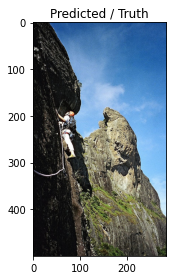

Prediction: 에서암벽등반을하고있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]암, 
Truth: 오렌지헬멧을쓴사람이깎아지른절벽얼굴을올라갑니다.


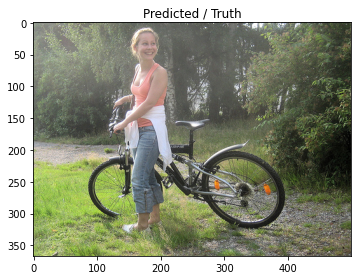

Prediction: 에서전하는소녀.[SEP]전화를위해포즈를취합니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP]포즈를취합니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]포즈를취합니다.[SEP][SEP]포함한잔디밭에있습니다.[SEP][SEP][SEP]가자전거를취합니다.[SEP]포함하여포함한잔디밭에있습니다.[SEP]포함하여포장도로의포장도로의자전거를취합니다.[SEP]트를취합니다.[SEP]저자, 
Truth: 여자는산림보호구역에서야외자전거를타는것을즐기고있습니다.


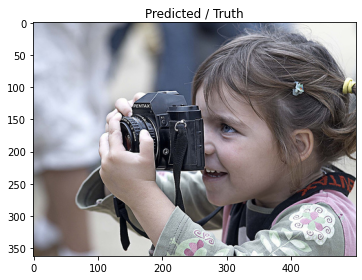

Prediction: 에서웃고있는소녀.[SEP]웃고있습니다.[SEP]그뒤에는웃고있습니다.[SEP]그뒤에는웃고있습니다.[SEP]그뒤에는웃고있습니다.[SEP]그뒤에는그뒤에는그뒤에는그뒤에는그뒤에웃고있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]그뒤에서있습니다.[SEP]그뒤에서있습니다.[SEP]그뒤에는웃고있습니다.[SEP]웃고있습니다.[SEP]그뒤에는웃고있습니다.[SEP]그뒤에는웃고있습니다., 
Truth: 소녀는카메라렌즈를손으로손으로사진을찍습니다.


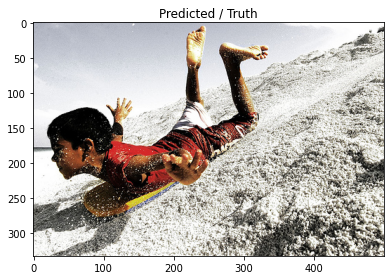

Prediction: 에있는소년은바다언덕을미끄러져내려다본다.[SEP].[SEP].[SEP]작은소년.[SEP].[SEP]작은배경.[SEP]작은배경에있습니다.[SEP]배경에있습니다.[SEP]배구름다운구름다운구름이배경에있습니다.[SEP]배구름이배경에배경에배경에배구름이배구름이있습니다.[SEP]배경에배구름다운배구름이있습니다.[SEP]배경에배낭이있습니다.[SEP], 
Truth: 모래모래언덕을썰매로썰매빨간셔츠를입은소년.


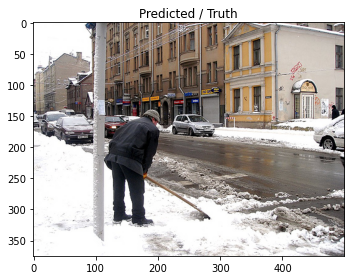

Prediction: 에서눈을삽질하는남자.[SEP]거리에서눈에띄는사람.[SEP].[SEP].[SEP].[SEP]스바닥에있습니다.[SEP]그뒤에서있습니다.[SEP]그뒤에는큰바지를입은남자.[SEP]그뒤에서있습니다.[SEP]그의사진을그의사진을찍고있습니다.[SEP]그뒤에서있습니다.[SEP]그의사진을찍고있습니다.[SEP]그의사진을찍고있습니다.[SEP]그의검은눈속눈에있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP], 
Truth: 남자가길을삽질했다.


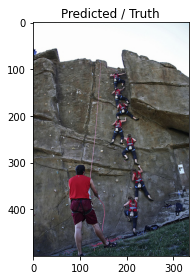

Prediction: 에서암벽등반을하고있습니다.[SEP]사람은바위가많은사람들이[SEP]계단을오르고있습니다.[SEP]바닥에있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]바닥에있습니다.[SEP]워있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP], 
Truth: 7명의등반가가바위얼굴을오름차순으로하고있는동안다른남자는밧줄을들고있습니다.


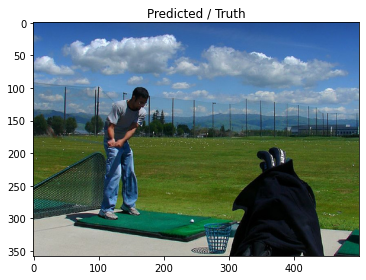

Prediction: 에서전시하는남자.[SEP]무언가를깎고있습니다.[SEP]그뒤에는뒤에는뒤에는나무가있습니다.[SEP]그뒤에있습니다.[SEP]그뒤에는큰골프그뒤에있습니다.[SEP]그뒤에는큰골프가있습니다.[SEP]그뒤에있습니다.[SEP]그뒤에있습니다.[SEP]그뒤에있습니다.[SEP]워있습니다.[SEP]그뒤에있습니다.[SEP]워있습니다.[SEP]그뒤에는뒤에는뒤에는큰잔디밭이있습니다.[SEP]그뒤에있습니다.[SEP], 
Truth: 청바지를입은한남자가운전범위에서골프스윙을연습합니다.


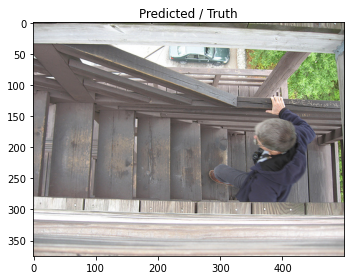

Prediction: 에서스웨터를착용한사람.[SEP]나무계단을오르고있습니다.[SEP]수나무를지나갑니다.[SEP]다리고있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP]수하철도구부러갑니다.[SEP]수있습니다.[SEP]가큰나무를가큰나무를가그뒤에다리를건너갑니다.[SEP]수행합니다.[SEP]수행합니다.[SEP]수있습니다.[SEP][SEP][SEP]계단에다.[SEP]수있습니다.[SEP]수있습니다, 
Truth: 회색재킷의남자는나무계단을올라갑니다.


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 1 summary:
Train loss: 1.1752, validation loss: 2.6283
Train accuracy: 0.4296, validation accuracy: 0.3120
Time per 1 epoch: 6.0 minutes
2/30 epoch.


  0%|          | 0/891 [00:00<?, ?it/s]

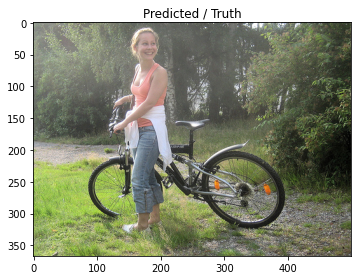

Prediction: 에서전하는소녀.[SEP]전화를위해포즈를취합니다.[SEP][SEP][SEP]어린소녀.[SEP]그뒤에있는잔디밭에서있습니다.[SEP]그뒤에자전거를취합니다.[SEP]그뒤에있습니다.[SEP]그뒤에있는소녀는소녀는다.[SEP][SEP][SEP][SEP][SEP]전거를취합니다.[SEP]그뒤에있습니다.[SEP]그뒤에있습니다.[SEP][SEP][SEP][SEP][SEP]그뒤에있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]그뒤에있습니다.[SEP][SEP], 
Truth: 여자는산림보호구역에서야외자전거를타는것을즐기고있습니다.


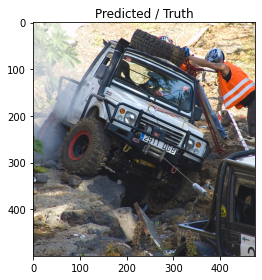

Prediction: 에서하하는오렌지조끼를입은남자.[SEP]도로옆에주차된차량을운전합니다.[SEP].[SEP]가로질러가려고합니다.[SEP].[SEP].[SEP].[SEP]가는것처럼보았습니다.[SEP]가는것처럼보입니다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]가는것을지않습니다.[SEP]어있습니다.[SEP]가는것처럼보입니다.[SEP]가는것처럼보입니다.[SEP]가는것처럼보입니다.[SEP]트럭에있습니다.[SEP]가는것처럼, 
Truth: 한무리의사람들이지프를바위에붙잡고있습니다.


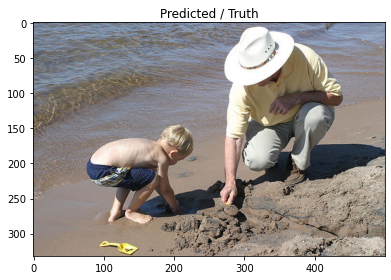

Prediction: 에서놀고있는두소년.[SEP]어린소녀.[SEP]무릎을꿇고있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]놀고있습니다.[SEP][SEP][SEP][SEP]놀고있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]놀고있습니다.[SEP]놀고있습니다.[SEP]놀고있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP]노란색과함께모래로모래로모래에서있습니다.[SEP][SEP][SEP][SEP]놀, 
Truth: 모자를입은모자를쓰고작은소년이모래에서연주하는수영복을입은작은소년.


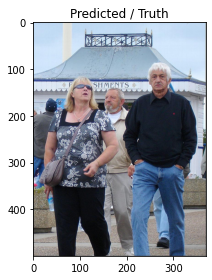

Prediction: 에서걷는여자와함께걷는다.[SEP].[SEP].[SEP]젊은여성.[SEP].[SEP].[SEP]가게[SEP]가게[SEP]다.[SEP]가게[SEP]다.[SEP]다.[SEP]가게밖에서있습니다.[SEP]다.[SEP]가게밖에서있습니다.[SEP]가게바라갑니다.[SEP]다.[SEP]가게밖에서있습니다.[SEP]다.[SEP]다.[SEP]다.[SEP]가게바라보는것처럼보도를걷는다.[SEP]다.[SEP]가게밖에서있습니다.[SEP]다.[SEP]다., 
Truth: 상쾌한스탠드앞에서있는남자와여자


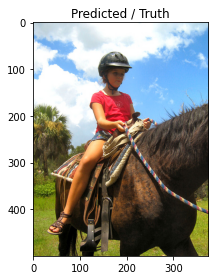

Prediction: 에앉아있는소녀.[SEP]갈색말을타고있습니다.[SEP]어린소녀.[SEP]갈색말을타고있습니다.[SEP]갈색말을타고있습니다.[SEP]갈색말을타고있습니다.[SEP]갈색말을타고있습니다.[SEP]안말을타고있습니다.[SEP]갈색말을타고있습니다.[SEP]갈색말을타고있습니다.[SEP]트셔츠를타고있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP], 
Truth: 헬멧을쓰고갈색말을타는어린소녀.


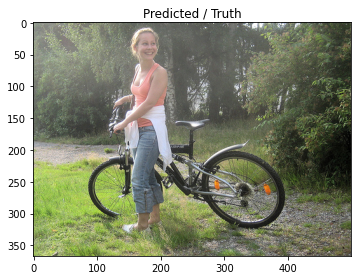

Prediction: 에서전하는소녀.[SEP]전화를위해포즈를취합니다.[SEP][SEP][SEP]어린소녀.[SEP]그뒤에있는포옹벽에있는포옹벽돌보입니다.[SEP]그뒤에서있습니다.[SEP]그뒤에서있습니다.[SEP]그뒤에자전거를취합니다.[SEP]그뒤에있는소녀.[SEP]그뒤에있는소녀는자전거를취합니다.[SEP]그뒤에있는포옹벽에있는소녀는자전거를취합니다.[SEP]그뒤에있는소녀는자전, 
Truth: 여자는산림보호구역에서야외자전거를타는것을즐기고있습니다.


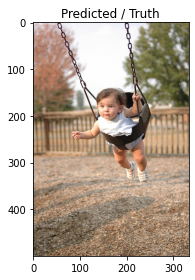

Prediction: 에서스윙에서스윙하는아이.[SEP][SEP]어린소녀.[SEP][SEP][SEP][SEP]스윙에서흔들립니다.[SEP]스윙세트에서흔들립니다.[SEP]고있습니다.[SEP]스윙에서흔들었다.[SEP]스윙합니다.[SEP]습니다.[SEP]습니다.[SEP]고있습니다.[SEP]고있습니다.[SEP]스윙합니다.[SEP]스윙에서흔들고있습니다.[SEP]스윙에서흔들고있습니다.[SEP]스윙에서흔들고있습니다.[SEP]고있습니다.[SEP]스윙에서흔들고있, 
Truth: 스윙에모든흰색스윙을착용한아기.


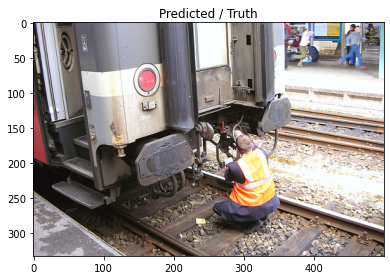

Prediction: 에서전하는기차에있는오렌지조끼를입은남자.[SEP]차.[SEP]무릎을꿇고있습니다.[SEP]그뒤에있습니다.[SEP]가그뒤에있습니다.[SEP]수있습니다.[SEP]가그뒤에있습니다.[SEP]수있습니다.[SEP]가그뒤에있습니다.[SEP]가그뒤에있습니다.[SEP]가그뒤에있습니다.[SEP]가그뒤에있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP]가고일부분수있습니다.[SEP]수있습니다.[SEP], 
Truth: 오렌지조끼를입은사람은기차를고치는작업을합니다.


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2 summary:
Train loss: 0.9801, validation loss: 2.5949
Train accuracy: 0.4607, validation accuracy: 0.3139
Time per 2 epoch: 13.0 minutes
Prediction after 2 epoch.


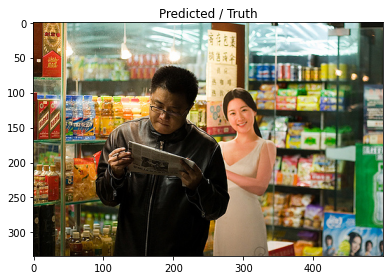

Prediction: 에서음료를마신사용하여앉아있는아시아남자.[SEP]가.[SEP]가루로질러걷는다.[SEP]가득찬안경을읽습니다.[SEP]가게뒤에서있습니다.[SEP]가게뒤에서있습니다.[SEP]가게합니다.[SEP]가게합니다.[SEP]가게앞에서있습니다.[SEP]가게뒤에있습니다.[SEP]가게앞에앉아있습니다.[SEP]가게뒤에있습니다.[SEP]가게뒤에있습니다.[SEP]가게뒤에있습니다.[SEP]그뒤에있습니다, 
Truth: 여자에게서잘라내기골판지옆에서있는중국인남자
3/30 epoch.


  0%|          | 0/891 [00:00<?, ?it/s]

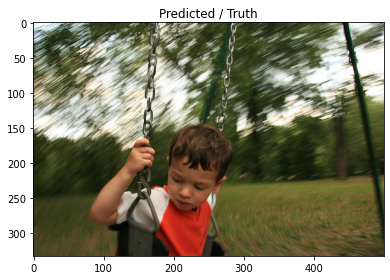

Prediction: 에서스윙에서놀고있는아이.[SEP]스윙[SEP].[SEP]어린소년.[SEP]스윙.[SEP]스윙.[SEP].[SEP]스윙.[SEP].[SEP].[SEP].[SEP].[SEP]스윙에서있습니다.[SEP]스윙에서있습니다.[SEP]가져있습니다.[SEP].[SEP]가져있습니다.[SEP]가져있습니다.[SEP]스윙세트를스윙세트를착용합니다.[SEP]스윙에서흔들고있습니다.[SEP]스윙에서흔들고있습니다.[SEP]스윙세트에스윙세트에있습니다, 
Truth: 오렌지와흰색의어린소년이공원의놀이터에서흔들립니다.


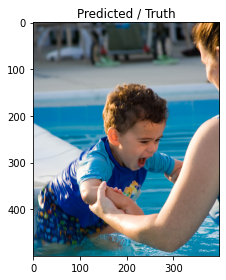

Prediction: 에서수영하는여자.[SEP]어린소년.[SEP]수영장의여자.[SEP].[SEP]약간에있습니다.[SEP]수영장으로뛰어들고있습니다.[SEP]수영장자리를잡고있습니다.[SEP]수영장으로뛰어들고있습니다.[SEP]수영장자리를잡고있습니다.[SEP]수영장으로뛰어들고있습니다.[SEP]수영장자리를잡고있습니다.[SEP]수영장으로뛰어들고있습니다.[SEP]수영장자리를잡고있습니다.[SEP]수영장으로, 
Truth: 아이는여자와함께수영합니다.


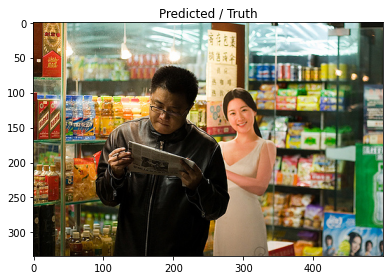

Prediction: 에서음료를마신사용하여앉아있는아시아남자.[SEP]가.[SEP]가루로질러걷는다.[SEP]가득찬안경을읽습니다.[SEP]가게뒤에서있습니다.[SEP]가게뒤에서있습니다.[SEP]가게합니다.[SEP]가게합니다.[SEP]가게뒤에있습니다.[SEP]가게뒤에있습니다.[SEP]가게뒤에신문을읽고있습니다.[SEP]가게뒤에신문을읽고있습니다.[SEP]가게뒤에신문을읽고있습니다.[SEP]가게뒤, 
Truth: 여자에게서잘라내기골판지옆에서있는중국인남자


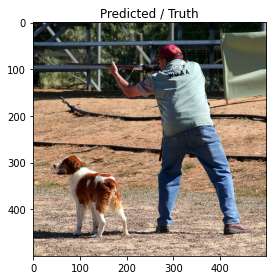

Prediction: 에달리는가죽끈을잡고있는남자.[SEP]무언가를촬영하는동안개.[SEP]가를촬영하려고합니다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP], 
Truth: 개가쳐다보면서남자가소총을쏴.


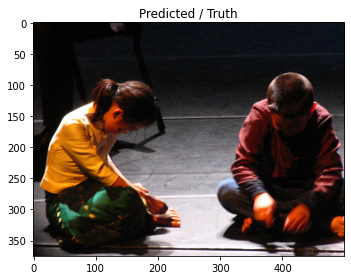

Prediction: 에서놀고있는두아이.[SEP]어린소녀.[SEP]함께놀고있습니다.[SEP]어져있습니다.[SEP]함께놀고있습니다.[SEP]함께놀고있습니다.[SEP]소년.[SEP]함께놀고있습니다.[SEP]함께놀고있습니다.[SEP]수있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]소녀.[SEP][SEP]수있습니다.[SEP]놀고있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]바닥에앉아있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP], 
Truth: 두자녀,소년과소녀,머리를아래로다리를교차시켰습니다.


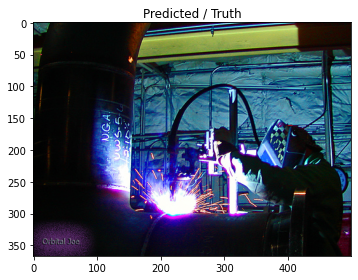

Prediction: 용접용접하는파이프를용접하는사람.[SEP]용접.[SEP].[SEP]스.[SEP]스캐스택이접용접용접용접용접용접용접용접기에서용접용접용접하고있습니다.[SEP]가가가가가가가가가가가가가가가가가가가가가가갑을용접용접용접용접용접하고있습니다.[SEP]작업하고있습니다.[SEP]작업하고있습니다.[SEP]작업을용접용접용접용접용접, 
Truth: 얼굴보호기능이있는작업자는기계를사용하고있습니다.


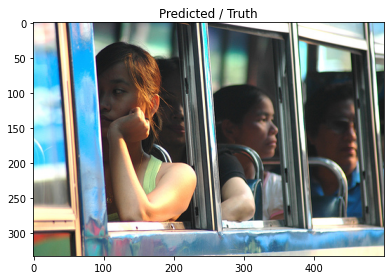

Prediction: 의창문에서있는동안한여성이바쁜거리를통해올라갑니다.[SEP]다.[SEP]습니다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]., 
Truth: 버스에서쳐다보는여자.


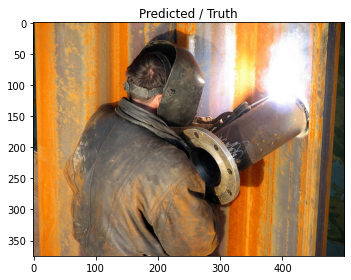

Prediction: 에서용접하는파이프를용접하는사람.[SEP].[SEP]작은금속막대에서수있습니다.[SEP]그의도구를용접시를용접합니다.[SEP]수있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP]가진사람이그의도구를작업을수있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP]조각형성된방해조각품을수있습니다.[SEP]작업을수있습니다.[SEP]금속막을수있습니다., 
Truth: 보호장비를착용한사람이강철빔을용접하고있습니다.


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3 summary:
Train loss: 0.9384, validation loss: 2.5950
Train accuracy: 0.4635, validation accuracy: 0.3140
Time per 3 epoch: 20.0 minutes
4/30 epoch.


  0%|          | 0/891 [00:00<?, ?it/s]

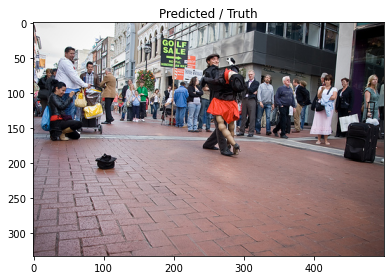

Prediction: 에서춤을추는남자와여자.[SEP]어린소년.[SEP]무술을연습하고있습니다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]가있습니다.[SEP]가달린다.[SEP]가달리고있습니다.[SEP]가달린이있습니다.[SEP]가달린다른사람들이그뒤에서춤을연주합니다.[SEP]가있습니다.[SEP]남자는모자를쓰고있습니다.[SEP]무술집앞에서춤을연주합니다.[SEP]가, 
Truth: 한쌍의댄서가붉은벽돌거리에서공연합니다.


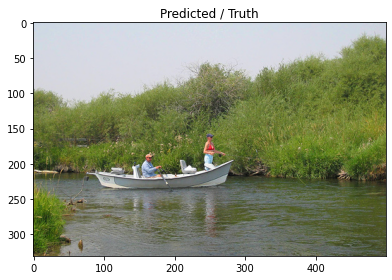

Prediction: 에서낚시를하는두사람.[SEP]약간에있는사람.[SEP]약간에있습니다.[SEP]그뒤에있습니다.[SEP]그뒤에는큰나무가있습니다.[SEP]그뒤에는큰나무가있습니다.[SEP]약간에서있습니다.[SEP]그뒤에서있습니다.[SEP]약간에서있습니다.[SEP]수있습니다.[SEP]수있습니다.[SEP]약간에있습니다.[SEP]그뒤에는큰나무로둘러보트는보트에서있습니다.[SEP][SEP][SEP][SEP][SEP]수있습니다.[SEP]수있습니다.[SEP], 
Truth: 작은강에서보트낚시를하는부부.


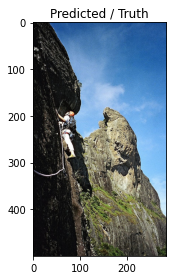

Prediction: 에서암벽등반[SEP]가.[SEP]암벽등반[SEP]가.[SEP]가.[SEP]포즈를취하고있습니다.[SEP][SEP]바위얼굴의바위얼굴에붙어있습니다.[SEP][SEP][SEP][SEP][SEP]있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]있습니다.[SEP][SEP][SEP]운전달려있습니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP], 
Truth: 오렌지헬멧을쓴사람이깎아지른절벽얼굴을올라갑니다.


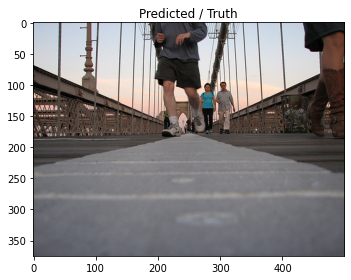

Prediction: 에서전하는사람들의그룹.[SEP]다리를가로질러걷는다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]행자들은다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]다.[SEP]다.[SEP]다.[SEP]다.[SEP]행자들은다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]행되고있습니다.[SEP]무큰흰색과함께자형성된보도트랙에서있습니다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]무큰흰색보도저녁행, 
Truth: 사람들은다리를가로질러우연히산책합니다.


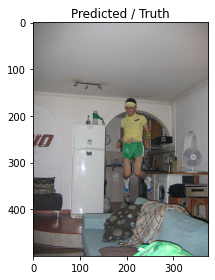

Prediction: 에서점프하는반바지를입은남자.[SEP]거실에서점프합니다.[SEP].[SEP].[SEP]구멍을뚫고있습니다.[SEP]수있습니다.[SEP]그뒤집습니다.[SEP]그뒤에있습니다.[SEP]그뒤에는큰바지를입은남자가있습니다.[SEP]그뒤에있습니다.[SEP]수있습니다.[SEP]그뒤집는공을수있습니다.[SEP]그뒤집고있습니다.[SEP]그뒤집고있습니다.[SEP]그뒤에있습니다.[SEP]그뒤집고있습니다.[SEP]그뒤, 
Truth: 노란셔츠를입은남자가점프하고있습니다.


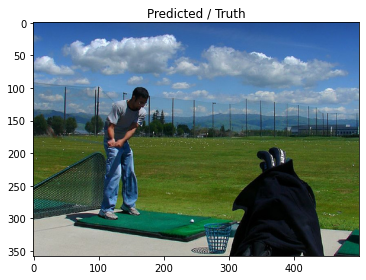

Prediction: 에서전시하는남자.[SEP]무언가를운전하는남자.[SEP]무언가를운전합니다.[SEP]가를운전합니다.[SEP]위해골프자전합니다.[SEP]뒤에서골프자세를있습니다.[SEP]그뒤에서있습니다.[SEP]그뒤에서있습니다.[SEP]가를운전거를운전합니다.[SEP]그뒤에서있습니다.[SEP]그뒤에서있습니다.[SEP]그뒤쪽으로칠해진운전합니다.[SEP]그뒤쪽으로골프자세를있습니다.[SEP]그뒤에있습니다.[SEP]뒤에서, 
Truth: 화창한날에한남자가골프연습.


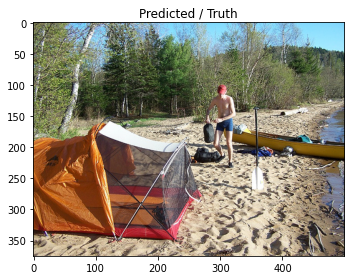

Prediction: 에해변에있는남자와여자는해안에있습니다.[SEP]그는백그라운드에있고다른남자가있습니다.[SEP]그라운드에있습니다.[SEP]그라운드에있습니다.[SEP]그라운드에있습니다.[SEP]그라운드에있습니다.[SEP]그라운드에있고해변에있습니다.[SEP]그라운드에있습니다.[SEP]그라운드에있고해변이있습니다.[SEP]그라운드에있습니다.[SEP]그라운드에있고해변해변해안에있습니다.[SEP]그라운드에있습니다.[SEP], 
Truth: 그남자는바다근처의해안에텐트를세우고있습니다.


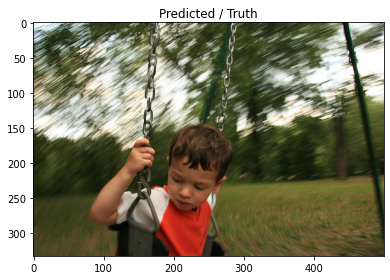

Prediction: 에서스윙하는소년.[SEP]스윙에서스윙하는소년.[SEP].[SEP].[SEP].[SEP]스윙.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]스윙[SEP]스윙에서있습니다.[SEP].[SEP].[SEP]스윙[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]스윙[SEP]스윙세트에서스윙세트에서흔들었습니다.[SEP]스윙[SEP].[SEP].[SEP]스윙[SEP]스윙[SEP].[SEP].[SEP].[SEP].[SEP]스윙세트에서있습니다.[SEP]스윙, 
Truth: 오렌지와흰색의어린소년이공원의놀이터에서흔들립니다.


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 4 summary:
Train loss: 0.9154, validation loss: 2.5976
Train accuracy: 0.4685, validation accuracy: 0.3141
Time per 4 epoch: 27.0 minutes
Prediction after 4 epoch.


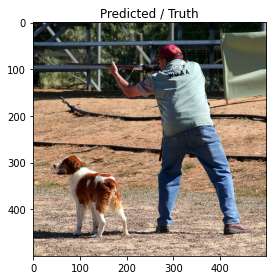

Prediction: 에서총을목표로하는사람.[SEP].[SEP].[SEP].[SEP]어린소녀.[SEP].[SEP].[SEP]무언가를향해달려갑니다.[SEP]무언가를지켜봅니다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]무릎을목표로총을목표로총을목표로총을목표로하는남자.[SEP]무언가를향해달리는옆으로바라본다.[SEP]무릎을목표로총을목표로하는, 
Truth: 개가쳐다보면서남자가소총을쏴.
5/30 epoch.


  0%|          | 0/891 [00:00<?, ?it/s]

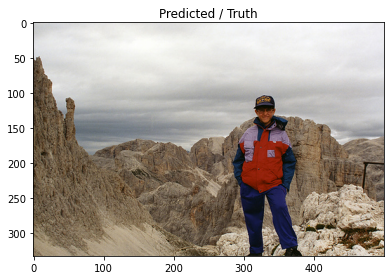

Prediction: 에서암벽등반하는하네스의어린이.[SEP]포즈를취합니다.[SEP].[SEP].[SEP].[SEP]포즈를취합니다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]포장도로에서있습니다.[SEP].[SEP].[SEP]포장도로의바위해포장도로의바위에서있습니다.[SEP]포즈를취합니다.[SEP]포즈를취합니다.[SEP]포즈를취합니다.[SEP]포즈를취합니다.[SEP]포즈를취합니다.[SEP]바위해포즈를취합니다., 
Truth: 안경을쓴소년은주머니에손이달린바위의봉우리위에서있습니다.


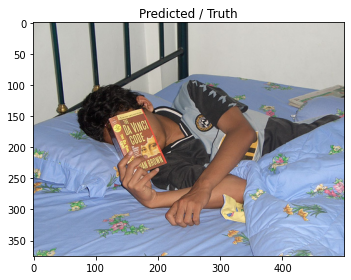

Prediction: 에서자고있는동안한남자가잠을자고있습니다.[SEP]그뒤에있습니다.[SEP]그는소파란색의자고있습니다.[SEP]잠을자고있습니다.[SEP]잠을자고있습니다.[SEP]잠들고있습니다.[SEP]잠을자고있습니다.[SEP]잠을자고있습니다.[SEP]잠을자고있습니다.[SEP]반자는남자는소파란색셔츠를자고있습니다.[SEP]잠들고있습니다.[SEP]잠들고있습니다.[SEP]잠을자고있습니다, 
Truth: DaVinci코드를읽는동안어린소년이잠들었습니다.


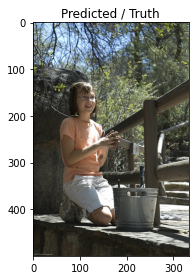

Prediction: 의가장자리에있는소녀가그녀의물앞에앉아있습니다.[SEP]그림을그리는것입니다.[SEP]그림을그리는것입니다.[SEP]무릎을꿇고있습니다.[SEP]그림을꿇고있습니다.[SEP]그녀의손에있습니다.[SEP]가있습니다.[SEP]가있습니다.[SEP]그림을꿇고무릎을꿇고무릎을꿇고있습니다.[SEP]그림벽앞에있습니다.[SEP]그림앞에손가있습니다.[SEP]그림벽앞에있, 
Truth: 더러운손을가진소녀는밖에서행복해보입니다.


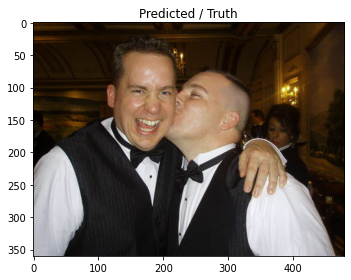

Prediction: 에서나옵니다.[SEP]는남자와여자.[SEP]남자.[SEP]그녀의뒤에있는다른남자.[SEP]가있습니다.[SEP]그뒤에있습니다.[SEP]그는그뒤에있습니다.[SEP]나란색티고다른남자는다른남자는그뒤에있습니다.[SEP]나란색티고다른남자는다른남자는다른남자는다른남자는다른남자는다른남자의모자를쓰고다른남자는다른남자는다른남자는다른남자는다른남자는다른남자의뺨을입고있습니다.[SEP]수있습니다, 
Truth: 한남자가수표에서다른남자에게키스하고둘다검은조끼로흰셔츠를입고있습니다.


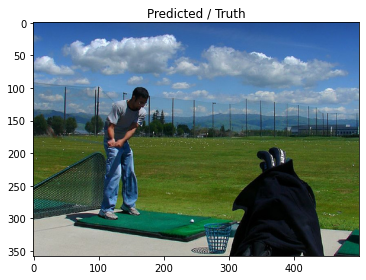

Prediction: 에서전시하는남자.[SEP]무언가를깎고있습니다.[SEP]그뒤에는뒤에는뒤에는큰골프공을볼수있습니다.[SEP]그뒤에있습니다.[SEP]그뒤에는큰골프공을수있습니다.[SEP]그뒤에있습니다.[SEP]그뒤에는뒤에는큰골프가있습니다.[SEP]그뒤에있습니다.[SEP]그뒤에있습니다.[SEP]그뒤에있습니다.[SEP]그뒤에있습니다.[SEP]그뒤에는뒤에는뒤에있습니다.[SEP]그뒤에는큰골프공을수있, 
Truth: 청바지를입은한남자가운전범위에서골프스윙을연습합니다.


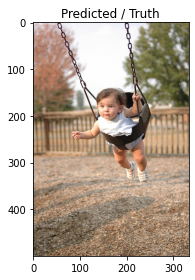

Prediction: 에서스윙에서스윙하는소녀.[SEP]아기.[SEP][SEP]어린소녀.[SEP]스윙에서흔들립니다.[SEP]스윙에서흔들립니다.[SEP]고있습니다.[SEP]스윙에서흔들립니다.[SEP]습니다.[SEP]습니다.[SEP]고있습니다.[SEP]고있습니다.[SEP]고있습니다.[SEP]고있습니다.[SEP]고있습니다.[SEP]스윙의스윙에서흔들었다.[SEP]스윙에서흔들고있습니다.[SEP]스윙에서흔들고있습니다.[SEP]스윙에서흔, 
Truth: 스윙에모든흰색스윙을착용한아기.


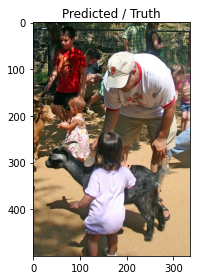

Prediction: 에서옷을입은남자는어린소녀를향해손을잡고있습니다.[SEP]어린소녀를만듭니다.[SEP]그녀의모두각시를보았습니다.[SEP]합니다.[SEP]합니다.[SEP]합니다.[SEP].[SEP]합니다.[SEP].[SEP].[SEP].[SEP].[SEP].[SEP].[SEP]무릎을만듭니다.[SEP]무릎을만듭니다.[SEP]무릎을만듭니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP].[SEP].[SEP].[SEP][SEP]무릎을만듭니다.[SEP], 
Truth: 어떤사람들은염소를보고쓰다듬고있습니다.


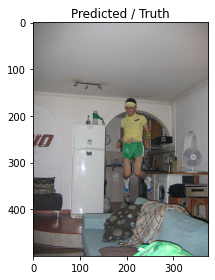

Prediction: 에서점프하는반바지를입은남자.[SEP]거실에서점프합니다.[SEP].[SEP].[SEP]구멍을뚫고있습니다.[SEP]수있습니다.[SEP]그뒤집고있습니다.[SEP]수있습니다.[SEP]그뒤에는큰바지를입은남자가있습니다.[SEP]그뒤집는공중간에있습니다.[SEP]그뒤집는공을수있습니다.[SEP]그뒤집고있습니다.[SEP]그뒤집고있습니다.[SEP]그뒤집고있습니다.[SEP]그뒤집고있습니다.[SEP]그, 
Truth: 노란셔츠를입은남자가점프하고있습니다.


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 5 summary:
Train loss: 0.8992, validation loss: 2.6057
Train accuracy: 0.4704, validation accuracy: 0.3154
Time per 5 epoch: 34.0 minutes


  0%|          | 0/100 [00:00<?, ?it/s]

KeyError: ('에서전시하는파란색셔츠를입은남자.[SEP]거리에서큰파란색과흰색모자가달린다.[SEP]그뒤에있는거리옆에서있습니다.[SEP].[SEP].[SEP]그뒤에는큰모자를쓰고있습니다.[SEP]그뒤에큰모자를쓰고있습니다.[SEP].[SEP].[SEP]그뒤에큰모자를쓰고있습니다.[SEP]그뒤에큰모자를쓰고있습니다.[SEP]그뒤에큰모자를쓰고있습니다.[SEP]그뒤에큰모자를쓰고있습니다.',)

In [38]:
train_losses, valid_losses, train_accuracies, valid_accuracies = [], [], [], []
timeout = 360.  # minutes before stop
start_time = time.time()

for epoch in range(EPOCHS):
    print(f'{epoch+1}/{EPOCHS} epoch.')
    epoch_train_losses, epoch_valid_losses, epoch_train_accuracy, epoch_valid_accuracy = [], [], [], []
    tk0 = tqdm(train_dataloader, total=len(train_dataloader), leave=True)
    
    for i, batch in enumerate(tk0):
        loss, train_accuracy = train_one_batch(model, batch, optimizer, criterion)
        epoch_train_losses.append(loss)
        epoch_train_accuracy.append(train_accuracy)
        tk0.set_postfix(loss=loss)
        if (i+1) % 100 == 0:
            pred = prediction(model)
        
    train_epoch_loss = np.array(epoch_train_losses).mean()
    train_losses.append(train_epoch_loss)
    train_accuracy = np.array(epoch_train_accuracy).mean()
    train_accuracies.append(train_accuracy)
    
    tk1 = tqdm(valid_dataloader, total=len(valid_dataloader), leave=True)
    for _, batch in enumerate(tk1):
        loss, valid_accuracy = validate_one_batch(model, batch, criterion)
        epoch_valid_losses.append(loss)
        epoch_valid_accuracy.append(valid_accuracy)
        tk1.set_postfix(loss=loss)
        
    valid_epoch_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(valid_epoch_loss)
    valid_accuracy = np.array(epoch_valid_accuracy).mean()
    valid_accuracies.append(valid_accuracy)
    
    print(f'Epoch {epoch+1} summary:')
    print(f'Train loss: {train_epoch_loss:.4f}, validation loss: {valid_epoch_loss:.4f}')
    print(f'Train accuracy: {train_accuracy:.4f}, validation accuracy: {valid_accuracy:.4f}')
    print(f'Time per {epoch+1} epoch: {(time.time() - start_time)//60} minutes')
    
    scheduler.step(valid_epoch_loss)
    
    if (epoch+1) % 2 == 0:
        print(f'Prediction after {epoch+1} epoch.')
        pred = prediction(model)
        torch.save(model.state_dict(), 'model.pth')
    
    if (epoch+1) % 5 == 0:
        test_bleu = evaluate_model(test_dataloader, model, corpus_bleu_score_fn, tokenizer)
        print(''.join([f'test_bleu{i}: {test_bleu[i]:.4f} ' for i in (1, 4)]))
        
    if (time.time() - start_time)//60 > timeout:
        print(f'Timeout stop.')
        torch.save(model.state_dict(), 'model.pth')
        break


#train은 가능합니다. 시간이 오래 걸려 일단은 중간에 멈췄습니다.
#슈퍼컴퓨팅 자원을 쓰면 쉽게 train 가능합니다.
#나희씨가 만드신 dataset도 전처리하면 이 모델에서 적용가능합니다. (description은 영어로 번역된 상태이긴 합니다.)

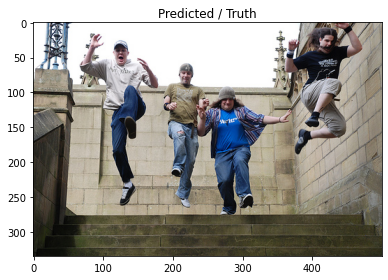

Prediction: 에서춤을추는남자와여자.[SEP]가서로마주보고있습니다.[SEP]그것을보고있습니다.[SEP]그것처럼보이는공중에있습니다.[SEP]수있습니다.[SEP]수영장을입은다른남자[SEP][SEP][SEP]수행합니다.[SEP]수행합니다.[SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP]배경에있습니다.[SEP]그들을입고있습니다.[SEP][SEP][SEP][SEP][SEP][SEP]배경의공중2명은그것처럼보이는공중하나는모자를쓰고있습니다, 
Truth: NO label


In [39]:
pred = prediction(model,filepath='/workspace/IMAGE/images/images/1001633352.jpg')
